# Continuous Control with 20 agents

---

## Preamble

### The project

In this notebook, we explore the use of parallel training of agents performing the same tasks. We collect the learning from all the agent and update an Actor-Critic network that represents the knowledge gathered by the different agents. A ll agents DDPG algorithm is used to solve a continuous control environment for the  [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

Before using this notebook check that you have followed the .Readme file available in [GitHub Project repository](https://github.com/BDGITAI/RL_P2_CONTINUOUS_CONTROL)

For the Notebook to work you will need the Reacher environment executable (for 20 agents) which was placed in [GitHub Project repository](https://github.com/BDGITAI/RL_P2_CONTINUOUS_CONTROL/Reacher_Windows_x86_64/). The environment needs to uncompressed as  `"./Reacher_windows_x86_64_20/Reacher.exe"`

This implementation uses the Pytorch library and was tested in a **Windows 64 bits** platform using **CPU**  computation. 


This notebook is divided in two parts
* **Part 1** : Training. We will train an Agent and see how the learning can be applied to execute a task
* **Part 2** : To see an already trained agent. You ll need to run the section 1.1 to get the import done but can skip the training section
* **Part 3** : To evaluate a trained agent over 100 episodes. You ll need to run the section 1.1 to get the import done but can skip the training section


### Base used for the project

[Shangtong Zhang](https://github.com/ShangtongZhang) implemented several agents and made the implementations in its GITHUB repository. This project is based on its work that was introduced in the Udacity's lectures.  
The base was created to interact with openai and atari environment.
This notebook highlights the modifications allowing the interactions with the Unity environment through the python API.

---


## 1. Part 1 : Training 20 agents 

In [1]:
!pip -q install ./python

In [10]:
import zipfile
zip_ref = zipfile.ZipFile('./data/Reacher_Linux_NoVis.zip', 'r')
zip_ref.extractall('./data/Reacher_Linux_NoVis/')
zip_ref.close()

In [2]:
import os
import stat

for dirpath, dirnames, filenames in os.walk('.'):
    for filename in filenames:
        path = os.path.join(dirpath, filename)
        os.chmod(path, 0o777) # for example

### 1.1 Imports and initialisation function
Import the deep_rl libraries from Shangtong and create a function creating the DDPG agent interacting with the Unity environment.

The initial approach would be to create 20 DDPG agents each one having their memory and actor critic network. Each agent could be trained in parallel for a given amount of timesteps. Then contents of all memories could be merged , one central network would be updated with the learning (forward and barkward pass). The resulting weights would then be copied into the 20 agents.
    1. Create 20 agents (threads)
    2. Each agents interact with environmnet for T_TIMESTEPS
    3. Once all thread are waiting, merge all memories into a central memory
    4. Perform Actor Critic Network update
    5. Update all agents with new weights
    6. Go to step 2 and repeat until end of episode


However, the unity environmnent contains the environment for all 20 agents. It implies that all 20 actions need to be given at the same time to update unity and get new states. This limits the use of thread to create parallel tasks.
Instead, the following cells create 20 agents that are called consecutively from the training loop. All share the same replay memory and network. The training first determine what actions are taken and uses the new states to update all agents.

To enable the training a new DDPG20 class is created to slit the step function in two parts : evaluation action , step the environmnent (see [DDPG.py](https://github.com/BDGITAI/RL_P2_CONTINUOUS_CONTROL/blob/master/deep_rl/agent/DDPG_agent.py)

In [3]:
from deep_rl import *

#
# Create a the Actor Critic Network that will be shared
# by all agents for evaluating actions. The unity environment requires all actions
# to be passed at once. Hence we can evaluate actions for the 20 agents successively
# and then step the environment. The unity env creates a bottleneck that limits the use
# of parallelism. With successive call there will be no competitive access to the network
# while training
# 

def shared_net(state_dim,action_dim):
     return (DeterministicActorCriticNet(
        state_dim, action_dim,
        actor_body=FCBody(state_dim, (400, 300), gate=F.tanh),
        critic_body=TwoLayerFCBodyWithAction(
            state_dim, action_dim, (400, 300), gate=F.tanh),
        actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-4),
        critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3)))

#
# Create a shared memory between 20 agents. 
# The stepping function of all agents will be called in sequence avoiding competing
# access when inserting or removing data from the memory
#   
def shared_mem():
    return Replay(memory_size=int(1e7), batch_size=64)  


#
# Create multiple agents
#
def create_agents(num_agent,net,target_net,mem):
    config = Config()
    log_dir = get_default_log_dir(create_agents.__name__)
    config.task_fn = lambda **kwargs: ContinuousControl(config.eval_env,log_dir=log_dir)
    config.eval_env = Unity20()
    config.max_steps = int(1e6)
    config.eval_interval = int(1e4)
    config.eval_episodes = 20
    config.discount = 0.99
    config.random_process_fn = lambda: OrnsteinUhlenbeckProcess(
        size=(config.action_dim, ), std=LinearSchedule(0.2))
    config.min_memory_size = 64
    config.target_network_mix = 1e-3
    #config.logger = get_logger()
    agents = []
    # create 20 agents 
    # the DDPG class is modified in a DDPG20 class to accomodate the training
    for i in range(num_agent):
        agents.append (DDPGAgent20(config,net,target_net,mem))
    return agents         

### 1.2 Training loop

In [4]:
def train(agents,n_episodes=2000, max_t=1000,score_target=30):
    scores = []     # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        # reset environment at the start of each episode
        states = agents[0].config.eval_env.reset()
        for agent,state in zip(agents,states):
            agent.state = state
        # no reward at start
        episode_rewards = np.zeros(len(agents))
        ep_scores = np.zeros(len(agents))
        for t in range(max_t):
            # decide wich action to take according to eps greedy policy
            actions = []
            for agent in agents:
                action = agent.half_step1()
                actions.append(action)
            # execute the action in the environment (interface with unity)
            next_states, rewards, dones, infos = agent.config.eval_env.step(actions)
            # store this experience in the memory and learn if enough experiences have been gathered
            for agent,action,next_state,reward,done,info in zip(agents,actions,next_states, rewards, dones, infos):
                agent.half_step2(action,next_state,reward,done,info)
            # update current state as next state
            for agent,state in zip(agents,next_states):
                agent.state = state
            # cumul reward
            ep_scores += rewards
            if np.any(dones):
                break 
        score = np.mean(ep_scores)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}\tMax Score: {:.2f}'.format(i_episode, np.mean(scores_window),np.max(scores_window)), end="")
        # save network weigth every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            path = 'checkpoint20_'+str(i_episode)+'.pth'
            agent.save(path)
            # save score
            f = open('output20.txt', 'w')
            f.write('score: '+ str(scores)+'\n')
            f.close()
        # target is 30 to win. 
        if np.mean(scores_window)>=score_target:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            path = 'checkpoint20_'+str(i_episode)+'.pth'
            agent.save(path)
            # save score
            f = open('output20.txt', 'w')
            f.write('score: '+ str(scores)+'\n')
            f.close()
            break
    return scores



### 1.3 Execute training loop 

In [5]:
# create default directories to maintain compatibility with the base
mkdir('data/video')
mkdir('dataset')
mkdir('log')

# train on CPU and not multi agent training
set_one_thread()
# train on CPU : -1 , GPU = 0
select_device(-1)
# create the agent
                   
# create a shared Network with observation dimensions = 33 and actions dimensions =4 (see .Readme)
network = shared_net(33,4)
# create a shared target Network with observation dimensions = 33 and actions dimensions =4 (see .Readme)
target_network = shared_net(33,4)
# create a shared replay memory to collect all data from all agents
replay = shared_mem()
# create agents
agents = create_agents(20,network,target_network,replay)
# start training , train on only half the required time steps to get different experiences quicker
scores = train(agents, n_episodes=1000, max_t=500, score_target =16.0)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 100	Average Score: 11.97	Max Score: 17.96
Episode 131	Average Score: 16.07	Max Score: 17.97
Environment solved in 31 episodes!	Average Score: 16.07


### 1.4 Plot the training results

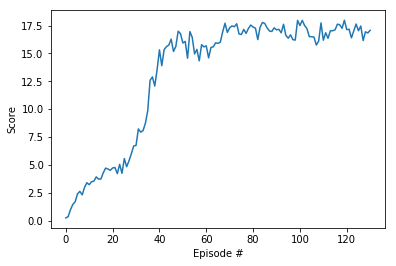

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 2. Part 2 : Watch a trained agent

Run the part 1.1 of this notebook to import the libraries and function definitions.

In [ ]:
# create a shared Network with observation dimensions = 33 and actions dimensions =4 (see .Readme)
network = shared_net(33,4)
# create a shared target Network with observation dimensions = 33 and actions dimensions =4 (see .Readme)
target_network = shared_net(33,4)
# create a shared replay memory to collect all data from all agents
replay = shared_mem()
# create agents
agents = create_agents(20,network,target_network,replay)
# initialise weights with learned ones
for agent in agents:
    agent.load('./successful_weigths/reacher_20.pth')
# Disable the training mode of the environmnet
brain_name = agents[0].config.eval_env.env.brain_names[0]
env_info = agents[0].config.eval_env.env.reset(train_mode=False)[brain_name] 
# reset states
states = env_info.vector_observations
scores = np.zeros(20)                        # initialize the score (for each agent)
while True:
    actions = []
    for agent,state in zip(agents,states):
        actions.append(agent.eval_step(state))
    # execute the action in the environment (interface with unity)
    env_info = agent.config.eval_env.env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += rewards                                  # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score this episode: {}'.format(np.mean(scores)))
agent.config.eval_env.close()

## 3. Part 3 : Evaluate a trained agent

Run the part 1.1 of this notebook to import the libraries and function definitions.

In [ ]:
import matplotlib.pyplot as plt

def eval(agents,n_episodes=100):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = agents[0].config.eval_env.env.reset(train_mode=False)[brain_name] 
        # reset states
        states = env_info.vector_observations
        scores = np.zeros(20)                        # initialize the score (for each agent)   
        actions = []
        for agent,state in zip(agents,states):
            actions.append(agent.eval_step(state))
        # execute the action in the environment (interface with unity)
        env_info = agent.config.eval_env.env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += rewards                                  # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
        score = np.mean(ep_scores)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}\tMax Score: {:.2f}}'.format(i_episode, np.mean(scores_window),np.max(scores_window)), end="")
    return scores

# create a shared Network with observation dimensions = 33 and actions dimensions =4 (see .Readme)
network = shared_net(33,4)
# create a shared target Network with observation dimensions = 33 and actions dimensions =4 (see .Readme)
target_network = shared_net(33,4)
# create a shared replay memory to collect all data from all agents
replay = shared_mem()
# create agents
agents = create_agents(20,network,target_network,replay)
# initialise weights with learned ones
for agent in agents:
    agent.load('./successful_weigths/reacher_20.pth')
# Disable the training mode of the environmnet
brain_name = agents[0].config.eval_env.env.brain_names[0]
env_info = agents[0].config.eval_env.env.reset(train_mode=False)[brain_name]

# evaluation
scores = eval(agents)


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

agents[0].config.eval_env.env.close()